In [1]:
import torch

from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
from torch_snippets import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import selectivesearch
from skimage.segmentation import felzenszwalb

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Reading Dataset

In [4]:
df11 = pd.read_csv('RCNN_dataset\df.csv')
df11.shape

(24062, 21)

In [5]:
df11.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


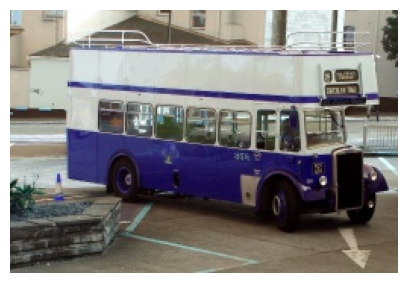

In [6]:
img_sample = cv2.imread('RCNN_dataset\\images\\00a56327032571c8.jpg')
img_sample.shape
show(img_sample)

(174, 256, 3)

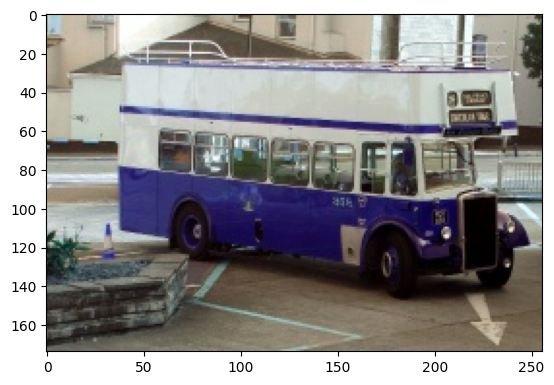

In [7]:
print(img_sample.shape)
plt.imshow(img_sample)

# Class Dataset

In [8]:
class OpenImages(Dataset):
    def __init__(self,df,image_folder="RCNN_dataset\\images"):
        self.root = image_folder
        self.df = df
        self.unique_imgs = df['ImageID'].unique()
        
    def __len__(self):
        return len(self.unique_imgs)
    
    def __getitem__(self, ix):
        image_id = self.unique_imgs[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

dataFrame = pd.read_csv("RCNN_dataset\\df.csv")
objOpenImages = OpenImages(dataFrame)
im, bbs, clss, _ = objOpenImages[999]

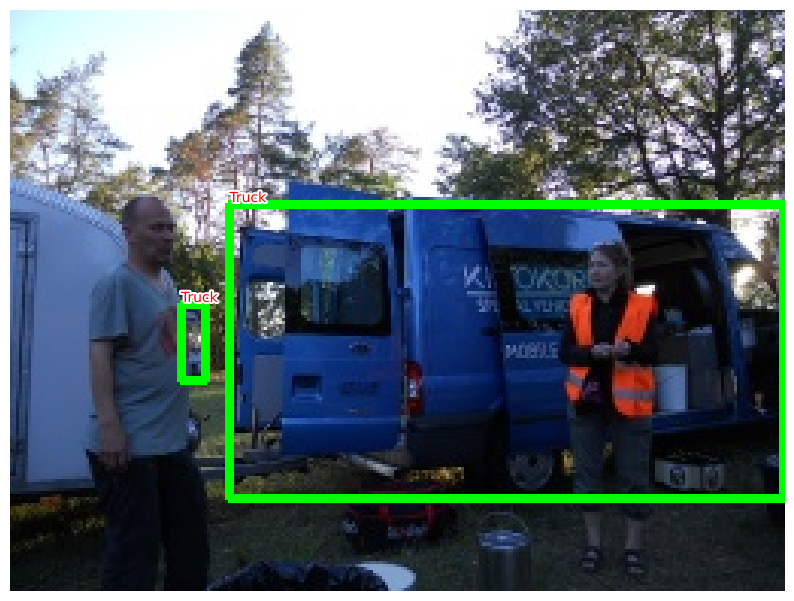

In [9]:
show(im, bbs=bbs, texts=clss, sz=10)

In [10]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

Initialize empty lists to store file paths (FPATHS), ground truth bounding
boxes (GTBBS), classes (CLSS) of objects, the delta offset of a bounding box
with region proposals (DELTAS), region proposal locations (ROIS), and the
IoU of region proposals with ground truths (IOUS):
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

In [25]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]
N = 3 # Taking 500 samples for further Training Propose

for ix,(img,bbs,labels,fpath) in enumerate(objOpenImages):
    if (ix==N):
        break
    #Extracting All Selective Searches from extractCandiates
    H,W,_ = img.shape
    candidates = extract_candidates(img)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    
#     Store the IoU of all candidates with respect to all ground truths for an
#     image where bbs is the ground truth bounding box of different objects
#     present in the image and candidates are the region proposal
#     candidates.
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

    for jx,candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        
#         If IoU (best_iou) is greater than a threshold (0.3), we assign the label
#         of class corresponding to the candidate, and the background
#         otherwise.
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
            
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'RCNN_dataset\\images\\{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [26]:
FPATHS

['RCNN_dataset\\images\\0000599864fd15b3.jpg',
 'RCNN_dataset\\images\\00006bdb1eb5cd74.jpg',
 'RCNN_dataset\\images\\00010bf498b64bab.jpg']

In [27]:
GTBBS

[[[88, 26, 232, 110]],
 [[70, 24, 178, 74], [179, 34, 255, 69]],
 [[40, 38, 95, 101]]]

In [28]:
CLSS

[['Bus',
  'Bus',
  'background',
  'Bus',
  'background',
  'background',
  'background',
  'background',
  'background',
  'Bus',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'Bus',
  'Bus',
  'background',
  'background',
  'background',
  'Bus',
  'background',
  'Bus',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'Bus',
  'background',
  'background',
  'background',
  'Bus',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background'],
 ['background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'Truck',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'Truck',
  'Truck',
  'background',
  'background',
  'backgroun

In [36]:
len(DELTAS),len(DELTAS[0]), DELTAS

(3,
 48,
 [[array([-0.2578125 , -0.08235294,  0.        ,  0.08235294]),
   array([-0.0390625 , -0.05882353,  0.        ,  0.08235294]),
   array([-0.203125  ,  0.15294118, -0.08984375,  0.40588235]),
   array([ 0.10546875, -0.03529412,  0.        ,  0.08235294]),
   array([-0.12890625,  0.15294118, -0.08984375,  0.40588235]),
   array([-0.12890625,  0.15294118, -0.08984375,  0.40588235]),
   array([ 0.34375   , -0.27058824,  0.42578125, -0.24117647]),
   array([-0.26171875, -0.35294118,  0.        , -0.22352941]),
   array([ 0.34375   , -0.04705882,  0.62109375,  0.02941176]),
   array([ 0.34375   , -0.04705882,  0.25390625, -0.01176471]),
   array([-0.07421875, -0.28823529,  0.26171875, -0.34705882]),
   array([ 0.25390625, -0.28823529,  0.26171875, -0.34705882]),
   array([-0.21484375, -0.35294118,  0.        , -0.23529412]),
   array([ 0.34375   , -0.27058824,  0.42578125, -0.24117647]),
   array([-0.21484375, -0.35294118, -0.0546875 , -0.23529412]),
   array([-0.21484375, -0.35294